In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
stop = EarlyStopping('val_loss', 1e-6, 5)
lr = ReduceLROnPlateau('val_loss', 0.2)
img_gen = ImageDataGenerator(height_shift_range=0.2, width_shift_range=0.2, shear_range=0.2,
                             horizontal_flip=True, vertical_flip=True)

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('train.csv')
label = train_data['label']
train_data = train_data.drop('label', axis=1)
train_data = np.array(train_data).reshape(-1, 28, 28, 1)


In [11]:
def classifier():
    clf = Sequential()
    clf.add(BatchNormalization(input_shape=(28, 28, 1)))
    clf.add(Conv2D(32, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(Conv2DTranspose(32, (3, 3), padding='same', activation='relu', bias_initializer='glorot_normal'))
    clf.add(MaxPooling2D())
    clf.add(Conv2D(64, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', bias_initializer='glorot_normal'))
    clf.add(MaxPooling2D())
    clf.add(Conv2D(128, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(Conv2DTranspose(128, (3, 3), padding='same', activation='relu', bias_initializer='glorot_normal'))
    clf.add(MaxPooling2D())
    clf.add(Flatten())
    clf.add(BatchNormalization())
    clf.add(Dense(units=64, activation='relu', bias_initializer='glorot_normal'))
    clf.add(Dropout(0.2))
    clf.add(Dense(units=32, activation='relu', bias_initializer='glorot_normal'))
    clf.add(Dropout(0.1))
    clf.add(Dense(units=10, activation='softmax', bias_initializer='glorot_normal'))
    opt = Adam(lr=0.003, decay=0.01)
    clf.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    clf.summary()
    return clf

model = classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)          0         
__________

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, to_categorical(label, 10), test_size=0.4)
img_gen.fit(x_train, True)

t0 = time()
batch = 32
epoch = 64
train_gen = img_gen.flow(x_train, y_train, batch)
valid_gen = img_gen.flow(x_valid, y_valid, batch)
train_steps = len(x_train) / batch
valid_steps = len(x_valid) / batch
his = model.fit_generator(generator=train_gen, steps_per_epoch=train_steps, epochs=epoch,
                          callbacks=[stop, lr], validation_data=valid_gen, validation_steps=valid_steps)

print('Time taken = %0.2f sec' % (time() - t0))


Epoch 1/64
788/787 [==============================] - 290s - loss: 1.4474 - categorical_accuracy: 0.5108 - val_loss: 2.4484 - val_categorical_accuracy: 0.3255
Epoch 2/64
788/787 [==============================] - 278s - loss: 0.8688 - categorical_accuracy: 0.7151 - val_loss: 0.7310 - val_categorical_accuracy: 0.7709
Epoch 3/64
788/787 [==============================] - 282s - loss: 0.7070 - categorical_accuracy: 0.7818 - val_loss: 0.5337 - val_categorical_accuracy: 0.8501
Epoch 4/64
788/787 [==============================] - 287s - loss: 0.6243 - categorical_accuracy: 0.8088 - val_loss: 0.5171 - val_categorical_accuracy: 0.8415
Epoch 5/64
788/787 [==============================] - 295s - loss: 0.5822 - categorical_accuracy: 0.8293 - val_loss: 0.5126 - val_categorical_accuracy: 0.8587
Epoch 6/64
788/787 [==============================] - 296s - loss: 0.5351 - categorical_accuracy: 0.8458 - val_loss: 0.4988 - val_categorical_accuracy: 0.8603
Epoch 7/64
788/787 [==========================

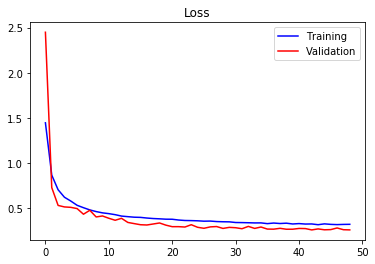

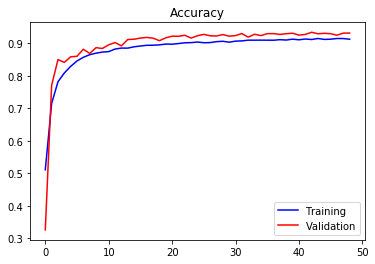

In [15]:
x = np.arange(len(his.epoch))
plt.figure(1)
plt.title("Loss")
plt.plot(x, his.history['loss'], 'b', label='Training')
plt.plot(x, his.history['val_loss'], 'r', label='Validation')
plt.legend()
plt.figure(2)
plt.title("Accuracy")
plt.plot(x, his.history['categorical_accuracy'], 'b', label='Training')
plt.plot(x, his.history['val_categorical_accuracy'], 'r', label='Validation')
plt.legend()
plt.show()
